<a href="https://colab.research.google.com/github/ADRIANVM117/data-science-portfolio/blob/main/Investment_Markowitz/Portafolios_Markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  7 of 7 completed
<ipython-input-8-9b73a654b5e0>:27: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


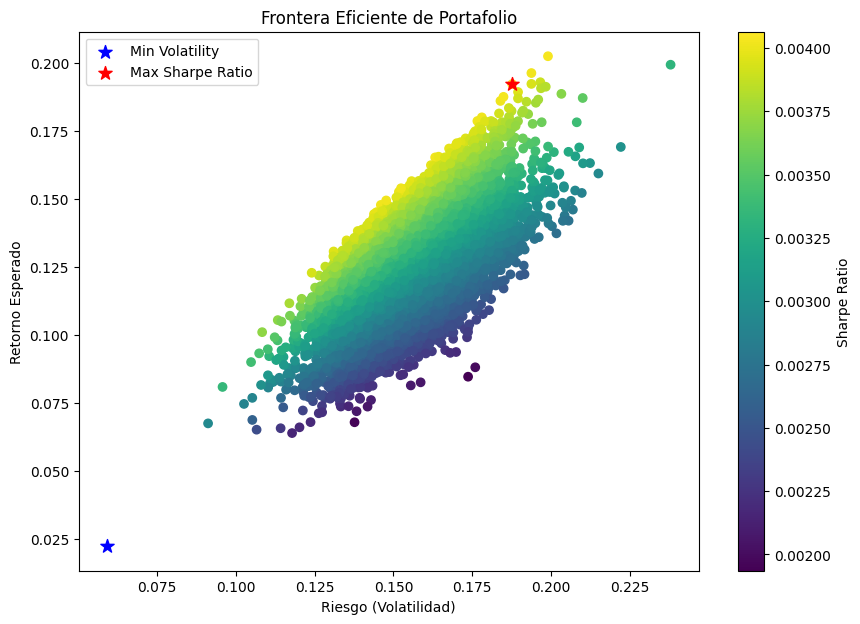

Pesos del Portafolio de Mínima Volatilidad: [1.42952052e-17 9.14456009e-01 1.61283969e-02 1.42962225e-17
 0.00000000e+00 6.94155941e-02 9.56827757e-18]
Retorno del Portafolio de Mínima Volatilidad: 0.02246227458533183
Riesgo del Portafolio de Mínima Volatilidad: 0.059080827054951504
Portafolio con Mayor Sharpe Ratio:
Retorno: 0.1922076095272729
Riesgo: 0.18765598750463608


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Seleccionar los ETFs a incluir en el portafolio

#AMZN	5.00%
#BND		10.00%
#CHDRAUIB.MX	30.00%
#VEA	10.00%
#VOO	25.00%
#VYM	10.00%
#XLRE 10.00%

tickerss = ['CHDRAUIB.MX','VEA','AMZN','BND', 'VOO','XLRE', 'VYM']  # Ejemplo de ETFs diversificados
#VOO: Exposición al mercado estadounidense.
#VEA: Diversificación internacional.
#BND: Bonos para estabilidad.
#XLRE: Exposición sectorial a bienes raíces.
#VYM: Dividendos para flujo de efectivo
# 2. Descargar los datos históricos de precios ajustados
data = yf.download(tickerss, start="2018-01-01", end="2024-11-13")["Adj Close"]

# 3. Calcular los rendimientos diarios de cada ETF
returns = data.pct_change().dropna()

# 4. Calcular las métricas de rendimientos
mean_returns = returns.mean()
cov_matrix = returns.cov()

# 5. Funciones de rendimiento y riesgo (volatilidad) del portafolio
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns) * 252  # Retorno anualizado
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # Riesgo anualizado
    return returns, risk

# 6. Función para minimizar: objetivo es la volatilidad (riesgo)
def min_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# 7. Restricciones: los pesos deben sumar 1 y cada peso debe estar entre 0 y 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickerss)))

# 8. Inicializar pesos y optimizar para encontrar el portafolio de mínima volatilidad
init_guess = len(tickerss) * [1. / len(tickerss)]
opt_results = minimize(min_volatility, init_guess, args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)

min_volatility_portfolio = opt_results.x  # Pesos óptimos de mínima volatilidad
min_volatility_return, min_volatility_risk = portfolio_performance(min_volatility_portfolio, mean_returns, cov_matrix)

# 9. Simulación para la frontera eficiente
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(tickerss))
    weights /= np.sum(weights)  # Normalizar para que sumen 1
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0, i] = portfolio_risk
    results[1, i] = portfolio_return
    results[2, i] = np.sum(weights * mean_returns) / portfolio_risk  # Sharpe ratio

# 10. Obtener el portafolio con mayor Sharpe Ratio
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[1, max_sharpe_idx]
max_sharpe_risk = results[0, max_sharpe_idx]

# 11. Graficar la frontera eficiente
plt.figure(figsize=(10, 7))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(min_volatility_risk, min_volatility_return, marker='*', color='b', s=100, label='Min Volatility')
plt.scatter(max_sharpe_risk, max_sharpe_return, marker='*', color='r', s=100, label='Max Sharpe Ratio')
plt.title('Frontera Eficiente de Portafolio')
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Esperado')
plt.legend()
plt.show()

# 12. Resultados del portafolio óptimo
print("Pesos del Portafolio de Mínima Volatilidad:", min_volatility_portfolio)
print("Retorno del Portafolio de Mínima Volatilidad:", min_volatility_return)
print("Riesgo del Portafolio de Mínima Volatilidad:", min_volatility_risk)

print("Portafolio con Mayor Sharpe Ratio:")
print("Retorno:", max_sharpe_return)
print("Riesgo:", max_sharpe_risk)

# 13. PESOS DEL PORTAFOLIO CON MAYOR SHARPE RATIO



In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

# Configuración de los tickers

tickers = tickerss # Ejemplo de ETFs diversificados
# Descargar los datos históricos de Yahoo Finance
precios = yf.download(tickers, start="2020-01-01", end="2024-11-12")['Adj Close']

# Calcular los retornos diarios
returns = precios.pct_change().dropna()

# Configuración inicial
num_activos = returns.shape[1]
num_portafolios = 100000  # Número de portafolios a simular
tasa_libre_riesgo = 0.05 / 252  # Tasa libre de riesgo diaria (ajusta según tu contexto)

# Almacenar resultados
resultados = np.zeros((3, num_portafolios))
pesos_portafolios = []

# Simulación de portafolios aleatorios
for i in range(num_portafolios):
    # Generar pesos aleatorios y normalizarlos para que sumen 1
    pesos = np.random.random(num_activos)
    pesos /= np.sum(pesos)
    pesos_portafolios.append(pesos)

    # Calcular retorno y volatilidad del portafolio
    retorno_portafolio = np.sum(returns.mean() * pesos) * 252  # Anualizar el retorno
    volatilidad_portafolio = np.sqrt(np.dot(pesos.T, np.dot(returns.cov() * 252, pesos)))  # Anualizar la volatilidad

    # Calcular el ratio de Sharpe
    sharpe_ratio = (retorno_portafolio - tasa_libre_riesgo * 252) / volatilidad_portafolio

    # Guardar resultados
    resultados[0, i] = retorno_portafolio
    resultados[1, i] = volatilidad_portafolio
    resultados[2, i] = sharpe_ratio

# Convertir resultados a DataFrame
resultados_df = pd.DataFrame(resultados.T, columns=['Retorno', 'Volatilidad', 'Sharpe Ratio'])
pesos_df = pd.DataFrame(pesos_portafolios, columns=returns.columns)

# Encontrar el portafolio con el mayor Sharpe Ratio
indice_mejor_sharpe = resultados_df['Sharpe Ratio'].idxmax()
mejores_pesos = pesos_df.iloc[indice_mejor_sharpe]

# Imprimir resultados
print("Pesos del portafolio con mayor Sharpe Ratio:")
print(mejores_pesos)
print("\nEstadísticas del portafolio con mayor Sharpe Ratio:")
print(resultados_df.iloc[indice_mejor_sharpe])


[*********************100%***********************]  7 of 7 completed
<ipython-input-9-852a8d09f094>:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = precios.pct_change().dropna()


Pesos del portafolio con mayor Sharpe Ratio:
Ticker
AMZN           0.167124
BND            0.000247
CHDRAUIB.MX    0.590215
VEA            0.042456
VOO            0.142039
VYM            0.001832
XLRE           0.056087
Name: 36843, dtype: float64

Estadísticas del portafolio con mayor Sharpe Ratio:
Retorno         0.276809
Volatilidad     0.212387
Sharpe Ratio    1.067901
Name: 36843, dtype: float64


In [ ]:
# EXTRAER SOLO LOS PESOS de mejores pesos
mejores_pesos.to_numpy()
# convertirlos en una lista
mejores_pesos.to_numpy().tolist()

[0.16712447245044168,
 0.0002467588148921581,
 0.5902153905035721,
 0.04245554001133648,
 0.14203923152331333,
 0.001831988313863549,
 0.056086618382580826]

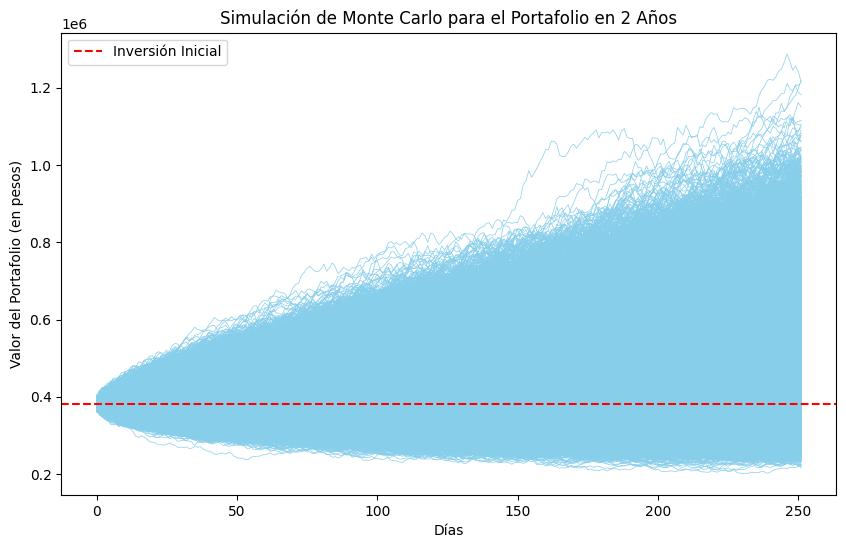

Valor promedio al final de 2 años: $503,867.89
Mediana del valor final: $492,655.62
Percentil 5% (escenario pesimista): $347,577.36
Percentil 95% (escenario optimista): $698,656.62


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuraciones de la simulación
num_simulaciones = 100000       # Número de simulaciones de Monte Carlo
dias = 252                 # 252 días de mercado por año * 2 años
inversion_inicial = 381901    # Inversión inicial en pesos

# Asumimos que ya tienes los datos históricos de retornos logarítmicos de tus ETFs en un DataFrame llamado `returns`
# Asegúrate de ajustar el DataFrame `returns` a tus datos de ETFs seleccionados

# Seleccionar los pesos óptimos basados en la maximización del ratio de Sharpe (o los que elijas)




pesos= [0.16712447245044168,
 0.0002467588148921581,
 0.5902153905035721,
 0.04245554001133648,
 0.14203923152331333,
 0.001831988313863549,
 0.056086618382580826]

# Calcular retorno promedio y matriz de covarianza de los retornos
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Preparar el array para almacenar los resultados de las simulaciones
simulaciones_portafolio = np.zeros((dias, num_simulaciones))

for i in range(num_simulaciones):
    # Generar una serie de rendimientos diarios para cada día del horizonte de tiempo
    rendimientos_diarios = np.random.multivariate_normal(mean_returns, cov_matrix, dias)

    # Calcular el valor del portafolio para cada día
    valor_portafolio = [inversion_inicial]
    for r in rendimientos_diarios:
        valor_portafolio.append(valor_portafolio[-1] * (1 + np.dot(pesos, r)))

    # Guardar la simulación completa
    simulaciones_portafolio[:, i] = valor_portafolio[1:]

# Visualización de los resultados
plt.figure(figsize=(10,6))
plt.plot(simulaciones_portafolio, color='skyblue', linewidth=0.5)
plt.xlabel('Días')
plt.ylabel('Valor del Portafolio (en pesos)')
plt.title('Simulación de Monte Carlo para el Portafolio en 2 Años')
plt.axhline(y=inversion_inicial, color='red', linestyle='--', label='Inversión Inicial')
plt.legend()
plt.show()

# Estadísticas de la simulación
valor_final_simulaciones = simulaciones_portafolio[-1]
media_final = np.mean(valor_final_simulaciones)
mediana_final = np.median(valor_final_simulaciones)
percentil_5 = np.percentile(valor_final_simulaciones, 5)
percentil_95 = np.percentile(valor_final_simulaciones, 95)

print(f"Valor promedio al final de 2 años: ${media_final:,.2f}")
print(f"Mediana del valor final: ${mediana_final:,.2f}")
print(f"Percentil 5% (escenario pesimista): ${percentil_5:,.2f}")
print(f"Percentil 95% (escenario optimista): ${percentil_95:,.2f}")


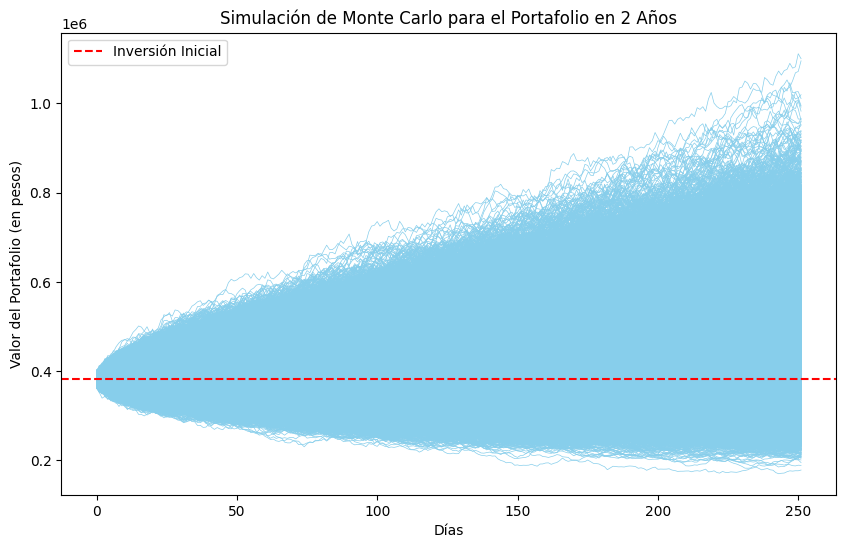

Valor promedio al final de 2 años: $457,228.41
Mediana del valor final: $448,136.25
Percentil 5% (escenario pesimista): $318,986.64
Percentil 95% (escenario optimista): $627,908.04


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuraciones de la simulación
num_simulaciones = 100000       # Número de simulaciones de Monte Carlo
dias = 252                 # 252 días de mercado por año * 2 años
inversion_inicial = 381901    # Inversión inicial en pesos

# Asumimos que ya tienes los datos históricos de retornos logarítmicos de tus ETFs en un DataFrame llamado `returns`
# Asegúrate de ajustar el DataFrame `returns` a tus datos de ETFs seleccionados

# Seleccionar los pesos óptimos basados en la maximización del ratio de Sharpe (o los que elijas)




pesos= [0.3893, 0.1469, 0.1167, 0.0486, 0.0409, 0.2062, 0.0313, 0.02]


# Calcular retorno promedio y matriz de covarianza de los retornos
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Preparar el array para almacenar los resultados de las simulaciones
simulaciones_portafolio = np.zeros((dias, num_simulaciones))

for i in range(num_simulaciones):
    # Generar una serie de rendimientos diarios para cada día del horizonte de tiempo
    rendimientos_diarios = np.random.multivariate_normal(mean_returns, cov_matrix, dias)

    # Calcular el valor del portafolio para cada día
    valor_portafolio = [inversion_inicial]
    for r in rendimientos_diarios:
        valor_portafolio.append(valor_portafolio[-1] * (1 + np.dot(pesos, r)))

    # Guardar la simulación completa
    simulaciones_portafolio[:, i] = valor_portafolio[1:]

# Visualización de los resultados
plt.figure(figsize=(10,6))
plt.plot(simulaciones_portafolio, color='skyblue', linewidth=0.5)
plt.xlabel('Días')
plt.ylabel('Valor del Portafolio (en pesos)')
plt.title('Simulación de Monte Carlo para el Portafolio en 2 Años')
plt.axhline(y=inversion_inicial, color='red', linestyle='--', label='Inversión Inicial')
plt.legend()
plt.show()

# Estadísticas de la simulación
valor_final_simulaciones = simulaciones_portafolio[-1]
media_final = np.mean(valor_final_simulaciones)
mediana_final = np.median(valor_final_simulaciones)
percentil_5 = np.percentile(valor_final_simulaciones, 5)
percentil_95 = np.percentile(valor_final_simulaciones, 95)

print(f"Valor promedio al final de 2 años: ${media_final:,.2f}")
print(f"Mediana del valor final: ${mediana_final:,.2f}")
print(f"Percentil 5% (escenario pesimista): ${percentil_5:,.2f}")
print(f"Percentil 95% (escenario optimista): ${percentil_95:,.2f}")
